### Solving Frozen Lake using Basic Q Learning
(Resolviendo Frozen Lake usando Basic Q Learning)

In [9]:
from stable_baselines3 import DQN

# Create the environment
env = PacManEnv()

# Create the DQN model
model = DQN('MlpPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=50000)

# Evaluate the model
episodes = 10
for episode in range(episodes):
    obs = env.reset()[0]
    done = False
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, _ = env.step(action)
        env.render()

env.close()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


TypeError: PacManEnv.reset() got an unexpected keyword argument 'seed'

In [7]:
import gymnasium as gym

from stable_baselines3 import DQN

env = gym.make("CartPole-v1", render_mode="human")

model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000, log_interval=4)
model.save("dqn_cartpole")

del model # remove to demonstrate saving and loading

model = DQN.load("dqn_cartpole")

obs, info = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        obs, info = env.reset()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27       |
|    ep_rew_mean      | 27       |
|    exploration_rate | 0.897    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 25       |
|    time_elapsed     | 4        |
|    total_timesteps  | 108      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.593    |
|    n_updates        | 1        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.1     |
|    ep_rew_mean      | 20.1     |
|    exploration_rate | 0.847    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 29       |
|    time_elapsed     | 5        |
|    total_timesteps  | 161      |
| train/              |        

KeyboardInterrupt: 

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Define the Q-network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
learning_rate = 0.001 # tasa de aprendizaje
discount_rate = 0.99 # tasa de descuento
epsilon = 1.0 # tasa de exploración. 1 = 100% de exploración
epsilon_decay_rate = 0.995 # tasa de decaimiento de la tasa de exploración
episodes = 10000 # número de episodios
batch_size = 64 # tamaño del lote para el entrenamiento
memory_size = 10000 # tamaño de la memoria para la repetición de experiencia
update_target_every = 5 # frecuencia de actualización de la red objetivo

# Inicializar el entorno y la red Q
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False, render_mode='rgb_array')
state_size = env.observation_space.n
action_size = env.action_space.n
q_network = QNetwork(state_size, action_size)
target_network = QNetwork(state_size, action_size)
target_network.load_state_dict(q_network.state_dict())
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size) # experiencia de memoria

# Función para preprocesar el estado
def preprocess_state(state):
    state_one_hot = np.zeros(state_size)
    state_one_hot[state] = 1
    return torch.tensor([state_one_hot], dtype=torch.float32)

# Función para seleccionar la acción
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            return q_network(preprocess_state(state)).argmax().item()

# Bucle de entrenamiento
rewards_per_episode = np.zeros(episodes) # recompensas por episodio
for episode in range(episodes):
    state = env.reset()[0]
    terminated = False
    truncated = False
    total_reward = 0

    while not terminated and not truncated:
        action = select_action(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        memory.append((state, action, reward, next_state, terminated))

        state = next_state
        total_reward += reward

        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.tensor(np.array([np.eye(state_size)[s] for s in states]), dtype=torch.float32)
            actions = torch.tensor(actions, dtype=torch.int64)
            rewards = torch.tensor(rewards, dtype=torch.float32)
            next_states = torch.tensor(np.array([np.eye(state_size)[s] for s in next_states]), dtype=torch.float32)
            dones = torch.tensor(dones, dtype=torch.float32)

            q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_q_values = target_network(next_states).max(1)[0]
            target_q_values = rewards + (discount_rate * next_q_values * (1 - dones))

            loss = nn.MSELoss()(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    epsilon = max(epsilon * epsilon_decay_rate, 0.1)
    rewards_per_episode[episode] = total_reward

    if episode % update_target_every == 0:
        target_network.load_state_dict(q_network.state_dict())

env.close()


### Results

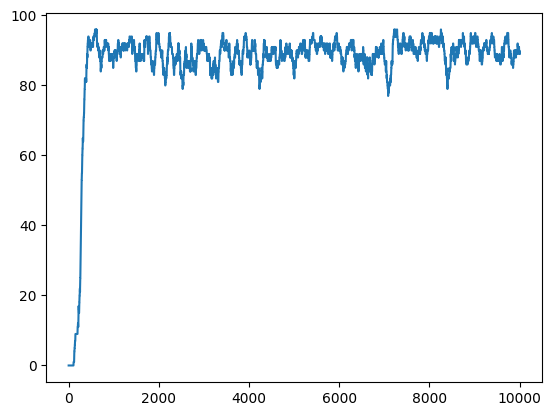

In [38]:
sum_rewards = np.zeros(episodes)
for t in range(episodes):
    sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])

plt.plot(sum_rewards)
plt.savefig('frozen_lake4x4.png')

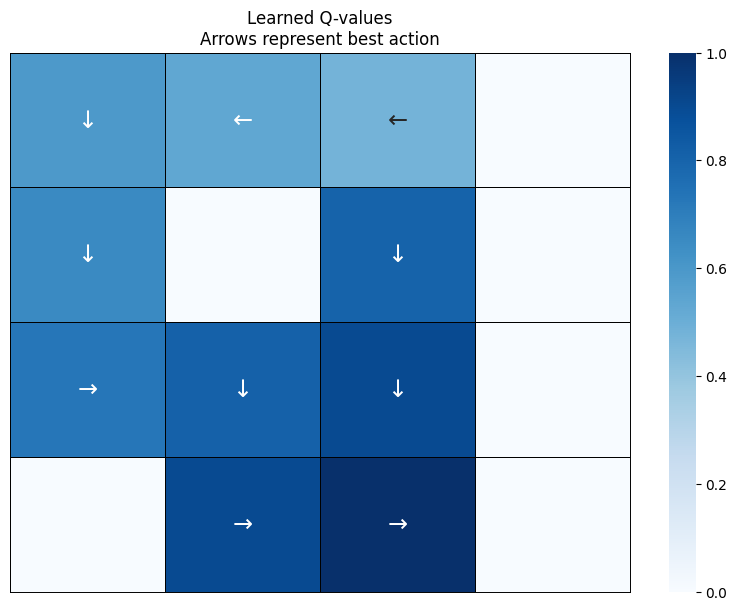

In [40]:
import sys
import os

# Add the parent directory to sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.plotting import plot_q_values_grid

plot_q_values_grid(q_table, 4)